In [1]:
# training_general_tensor-with_augment_layer
# pip install opencv-python

In [1]:
import matplotlib
import sklearn
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import pathlib
import os
import cv2
import datetime

from os import listdir
from os.path import isfile, isdir, join
from pathlib import Path

#os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.8/bin")
#os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.8/libnvvp")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from keras.models import load_model

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)

Versions of key libraries
---
tensorflow:  2.8.3
numpy:       1.23.4
matplotlib:  3.6.1
sklearn:     1.1.2


In [2]:
modelname   = ' multiclass'

IMG_SIZE = 224 #224 # Specify height and width of image to match the input format of the model
IMG_WIDTH = 224 #224  #IMG_SIZE
IMG_HEIGHT = 160  #160  #IMG_SIZE
CHANNELS = 3 # Keep RGB color channels to match the input format of the model
BATCH_SIZE = 64 # Big enough to measure an F1-score
AUTOTUNE = tf.data.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations
SEED = 7
N_LABELS = 0
EPOCHS = 50
OPT_IDX = 2
ACTIVATION = 'softmax'

class_names = []
modelname = modelname+"_"+str(IMG_SIZE)+"_"+str(EPOCHS)+"_"+str(BATCH_SIZE)+"_"+str(OPT_IDX)
optmzs = ['adam', optimizers.RMSprop(learning_rate=0.001), optimizers.Adam(learning_rate=0.001)]
optmz = optmzs[OPT_IDX]

In [3]:
def readImagesFromDir(base_img_path='dataset/'):
    dirs = [d for d in listdir(base_img_path) if isdir(join(base_img_path, d)) and not d.startswith('.') and not d in ['oranda', 'common_goldfish']]

    print(dirs)

    X, y = [], []

    for d in dirs:
        img_path = base_img_path + d + "/"
        files = [f for f in listdir(img_path) if isfile(join(img_path, f))]
        X = X + [os.path.join(img_path, f) for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        y = y + [d for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        #print(d)

    data_dir = Path(base_img_path)
    image_count = len(list(data_dir.glob('*/*.*')))
    
    return X, y


def preprocess_image(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    #image_resized = tf.image.resize(image_decoded, [IMG_HEIGHT, IMG_WIDTH], preserve_aspect_ratio=True)
    image_resized = tf.image.resize_with_pad(image_decoded, IMG_HEIGHT, IMG_WIDTH, antialias=False)
    #image_cropped = tf.image.random_crop(image_resized, [IMG_HEIGHT, IMG_WIDTH, CHANNELS])
    #image_rotated = tf.image.rot90(image_resized, k=0)
    #image_flip = tf.image.flip_left_right(image_rotated)
    # Normalise the image
    #visualize_image(image_cropped, image_rotated)
    image_normalized = image_resized / 255.0
    
    return image_normalized, label


def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        #dataset = dataset.take(BATCH_SIZE)
        # This is a small dataset, only load it once, and keep it in memory.
        #dataset = dataset.cache()
        #dataset = dataset.repeat()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        #dataset = dataset.repeat()
        
    # Batch the data for multiple steps    
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset
    
def visualize_image(original, augmented):
    org_img = tf.keras.utils.array_to_img(original)
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(org_img)

    aug_img = tf.keras.utils.array_to_img(augmented)
    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(aug_img)


def predict_new_image(img_file):    
    #img = tf.keras.utils.load_img(
    #    img_file, target_size=(IMG_HEIGHT, IMG_WIDTH), keep_aspect_ratio=True
    #)
    #img = tf.keras.utils.load_img(
    #    img_file, target_size=None, keep_aspect_ratio=True
    #)
    img = tf.keras.utils.load_img(
        img_file, target_size=None
    )

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.keras.preprocessing.image.smart_resize(img_array, size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    image_normalized = img_array / 255.0  # tf.image.per_image_standardization(img_array)

    saved_model = load_model(model_file)

    predictions = saved_model.predict(image_normalized)
    score = tf.nn.softmax(predictions[0])
    #score = tf.sigmoid(predictions[0])
    #score = tf.nn.sigmoid_cross_entropy_with_logits(labels=class_names, logits=predictions[0])
    #score = tf.math.sigmoid(predictions[0])
    #score = tf.tanh(predictions[0])

    #model.evaluate(img_array)
    plt.imshow(img)
    plt.show()

    #print(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    print()

In [4]:
X, Y = readImagesFromDir()

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=SEED)

lb = LabelBinarizer()
lb.fit(y_train)
class_names = lb.classes_
# Loop over all labels and show them    
N_LABELS = len(class_names)
for (i, label) in enumerate(class_names):
    print("{}. {}".format(i, label))

# transform the targets of the training and test sets
y_train_bin = lb.transform(y_train)
y_val_bin = lb.transform(y_val)

print(y_train_bin.shape)
print(y_val_bin.shape)

['arrowana', 'betta', 'goldfish', 'luohan']
0. arrowana
1. betta
2. goldfish
3. luohan
(6705, 4)
(1677, 4)


In [5]:
# Print examples of fish and their binary targets
for i in range(10):
    print(X_train[len(X_train)-1 - i], y_train_bin[len(y_train_bin)-1 - i])

dataset/arrowana/Arowana_100537.jpg [1 0 0 0]
dataset/goldfish/Goldfish2685.jpg [0 0 1 0]
dataset/goldfish/Goldfish1253.jpg [0 0 1 0]
dataset/arrowana/Arowana_100919.jpg [1 0 0 0]
dataset/arrowana/Arowana_101372.jpg [1 0 0 0]
dataset/luohan/Flowerhorn11359.jpg [0 0 0 1]
dataset/betta/BettaFish10573.jpg [0 1 0 0]
dataset/goldfish/Goldfish1387.jpg [0 0 1 0]
dataset/betta/BettaFish11229.jpg [0 1 0 0]
dataset/goldfish/Goldfish3104.jpg [0 0 1 0]


Shape of features array: (64, 160, 224, 3)
Shape of labels array: (64, 4)


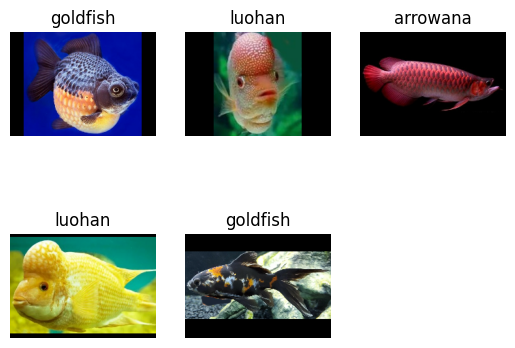

In [6]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin, is_training=False)


for images, labels in train_ds.take(1):
    print("Shape of features array:", images.numpy().shape)
    print("Shape of labels array:", labels.numpy().shape)
    #plt.imshow(f.numpy().astype("uint8"))
    for i in range(5):
        ax = plt.subplot(2, 3, i + 1)
        img = tf.keras.utils.array_to_img(images[i])
        plt.imshow(img)
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    

In [7]:
#image_augmentation = keras.Sequential([layers.RandomFlip(mode="horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS), seed=SEED), layers.RandomRotation(0.2, seed=SEED), layers.RandomZoom(height_factor = -0.3, width_factor = -0.3, fill_mode='reflect', interpolation='bilinear', seed= SEED)])
image_augmentation = keras.Sequential([layers.RandomFlip(mode="horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS), seed=SEED), layers.RandomRotation(0.2, seed=SEED)])

#image_augmentation = keras.Sequential(
#  [
#    layers.RandomFlip(mode="horizontal_and_vertical",
#                      input_shape=(IMG_HEIGHT,
#                                   IMG_WIDTH,
#                                   CHANNELS), seed=SEED),
#    layers.RandomRotation(0.2, seed=SEED)
#    #layers.RandomZoom(0.2, (0.2, 0.3)),
#  ]    
#)


In [8]:
def createModel():
    model = Sequential()
    model.add(image_augmentation)
    model.add(Conv2D(256, (5,5), padding='same', input_shape=(IMG_HEIGHT,IMG_WIDTH,CHANNELS), kernel_initializer='he_normal', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    #model.add(Conv2D(256, (6,6), padding='same', kernel_initializer='he_normal', activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2,2)))
    #model.add(Conv2D(32, (5,5), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2,2)))
    #model.add(Conv2D(64, (4,4), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128, (4,4), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0012), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    #model.add(Dropout(0.2))
    #model.add(Conv2D(128, (6,6), padding='same', kernel_initializer='he_normal', activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, (4,4), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0012), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    #model.add(Dropout(0.2))
    model.add(Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    #model.add(Conv2D(1024, (2,2), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    #model.add(Dense(768, activation='relu'))
    #model.add(Dense(512, activation='relu'))
    #model.add(Dense(256, activation='relu'))
    #model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(N_LABELS, activation=ACTIVATION))
    model.compile(loss='categorical_crossentropy', optimizer=optmz, metrics=['accuracy'])
    return model

model       = createModel() # This is meant for training
modelGo     = createModel() # This is used for final testing

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 160, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 160, 224, 256)     19456     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 112, 256)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 80, 112, 256)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 112, 128)      524416    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 40, 56, 128)      0         
 2D)                                                  

In [9]:
                                                                                # Step 1
modelname       = modelname+"_"+str(datetime.datetime.now())[:-7].replace(' ','_').replace(":",'-')
folderpath      = 'models/'
model_file      = folderpath + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(model_file, 
                                  monitor='val_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

csv_logger      = CSVLogger(folderpath+modelname +'.csv')                       # Step 2
callbacks_list  = [checkpoint,csv_logger]                                       # Step 3

print("Path to model:", model_file)
print("Path to log:  ", folderpath+modelname+'.csv')

Path to model: models/ multiclass_224_50_64_2_2022-10-27_15-06-09.hdf5
Path to log:   models/ multiclass_224_50_64_2_2022-10-27_15-06-09.csv


In [10]:
plotpath  = folderpath+modelname+'_plot.png'
plot_model(model, 
           to_file=plotpath, 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')
print("Path to plot:", plotpath)

Path to plot: models/ multiclass_224_50_64_2_2022-10-27_15-06-09_plot.png


In [11]:
import time as time
import winsound

start = time.time()
history = model.fit(train_ds,                            # Training data and label
          validation_data=val_ds,   # Validation data and label
          epochs=EPOCHS,                       # The amount of epochs to be trained
          batch_size=BATCH_SIZE,                   
          shuffle=True,                     # To shuffle the training data
          verbose=0,
          callbacks=callbacks_list)         # Callbacks to execute the checkpoints

end = time.time()
duration = round(((end - start)/60), 2)
print("duration = ", duration, " minutes")
winsound.Beep(480, 500)

duration =  27.87  minutes


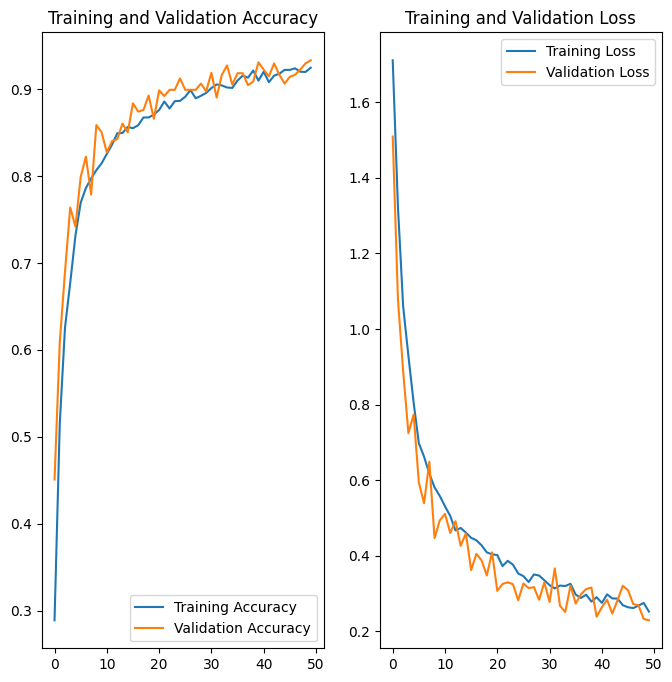

In [12]:
# Plot the accuracy and error on training and test sets

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(folderpath+modelname+'_accuracy_plot.png')
plt.show()

In [13]:
                                                                                # Step 1
modelGo.load_weights(model_file)
modelGo.compile(loss='categorical_crossentropy', 
                optimizer=optmz, 
                metrics=['accuracy'])

predicts    = modelGo.predict(val_ds)                                            # Step 2
print("Prediction completes.")

Prediction completes.


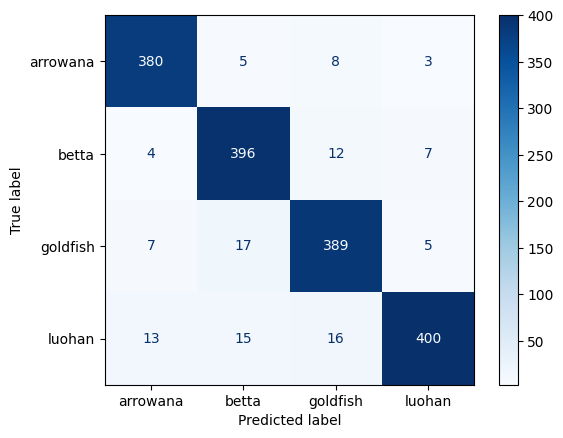

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_val_bin.argmax(axis = 1), predicts.argmax(axis = 1))

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_names)

disp.plot(cmap = plt.cm.Blues)
plt.show()

In [15]:
                                                                                # Step 1
                                                                                # Step 2
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(y_val_bin,axis=1)

testScores  = metrics.accuracy_score(testout,predout)                           # Step 3

                                                                                # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=class_names,
                                    digits=4))

report = metrics.classification_report(testout,
                                    predout,
                                    target_names=class_names,
                                    digits=4,
                                      output_dict=True)

df = pd.DataFrame(report).transpose()
df.to_csv(folderpath+modelname+'_report.csv')

Best accuracy (on testing dataset): 93.32%
              precision    recall  f1-score   support

    arrowana     0.9406    0.9596    0.9500       396
       betta     0.9145    0.9451    0.9296       419
    goldfish     0.9153    0.9306    0.9229       418
      luohan     0.9639    0.9009    0.9313       444

    accuracy                         0.9332      1677
   macro avg     0.9336    0.9341    0.9334      1677
weighted avg     0.9339    0.9332    0.9332      1677



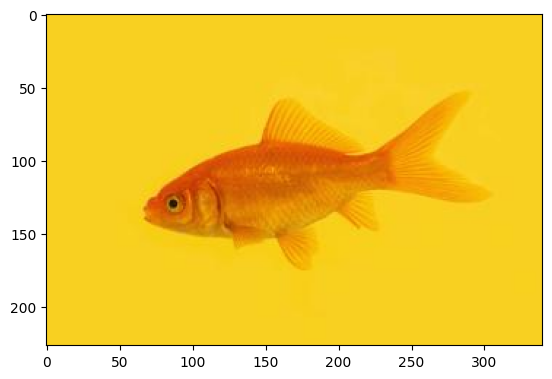

In [ ]:
# make predictions
predict_new_image("validate/261964-340x227-goldfish.jpg")
predict_new_image("validate/betta1.jpg")
predict_new_image("validate/flowerhorn-questions-answer.jpg")
predict_new_image("validate/273945-995d376a77e9f3e2fb2c216366a6bac1.jpg")

predict_new_image("validate/Screenshot 2022-09-08 210113.jpg")
predict_new_image("validate/arrowana125.jpg")
#predict_new_image("validate/0221faa8b79c4b2eb4dfee6f46912d74.jpg")
predict_new_image("validate/Screenshot 2022-09-22 015830.jpg")
predict_new_image("validate/jin_gan_luohan_fish_1558328530_b38f1646_progressive.jpg")
predict_new_image("validate/word-image.jpeg")


In [17]:
resdf = pd.DataFrame()
resdf["file"] = X_val
resdf["fish"] = y_val
resdf["testout"] = testout
resdf["predout"] = predout
print(resdf)

                                     file      fish  testout  predout
0        dataset/betta/BettaFish10363.jpg     betta        1        1
1       dataset/goldfish/Goldfish2398.jpg  goldfish        2        2
2        dataset/betta/BettaFish10959.jpg     betta        1        1
3      dataset/luohan/Flowerhorn10482.jpg    luohan        3        3
4     dataset/arrowana/Arowana_101642.jpg  arrowana        0        0
...                                   ...       ...      ...      ...
1672   dataset/luohan/Flowerhorn10551.jpg    luohan        3        3
1673   dataset/luohan/Flowerhorn10361.jpg    luohan        3        3
1674    dataset/goldfish/Goldfish2515.jpg  goldfish        2        2
1675  dataset/arrowana/Arowana_101040.jpg  arrowana        0        0
1676    dataset/goldfish/Goldfish1629.jpg  goldfish        2        0

[1677 rows x 4 columns]


In [18]:
resdf[resdf.testout !=resdf.predout]

,file,fish,testout,predout
10,dataset/luohan/Flowerhorn11902.jpg,luohan,3,0
21,dataset/goldfish/Goldfish1919.jpg,goldfish,2,0
22,dataset/goldfish/Goldfish2653.jpg,goldfish,2,1
23,dataset/arrowana/Arowana_100701.jpg,arrowana,0,2
39,dataset/goldfish/Goldfish2450.jpg,goldfish,2,1
...,...,...,...,...
1625,dataset/arrowana/Arowana_101837.jpg,arrowana,0,2
1645,dataset/luohan/Flowerhorn10531.jpg,luohan,3,2
1657,dataset/luohan/Flowerhorn11757.jpg,luohan,3,2
1660,dataset/luohan/Flowerhorn10628.jpg,luohan,3,1
